In [39]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from imblearn.over_sampling import SMOTE
from scipy.sparse import csr_matrix

# Load the dataset

In [40]:
ratings = pd.read_csv("archive\\rating.csv",nrows=10000)
movies=pd.read_csv("archive\\movie.csv",nrows=10000)

# Merging dataset movies and ratings on movieId
df=pd.merge(movies,ratings,on='movieId')
print(df.head())

   movieId             title                                       genres  \
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
1        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
2        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
3        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
4        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   

   userId  rating            timestamp  
0       3     4.0  1999-12-11 13:36:47  
1       6     5.0  1997-03-13 17:50:52  
2       8     4.0  1996-06-05 13:37:51  
3      10     4.0  1999-11-25 02:44:47  
4      11     4.5  2009-01-02 01:13:41  


# Exploratory Data Analysis

In [41]:
df.shape

(9273, 6)

In [42]:
df.size

55638

In [43]:
df.columns

Index(['movieId', 'title', 'genres', 'userId', 'rating', 'timestamp'], dtype='object')

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9273 entries, 0 to 9272
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   movieId    9273 non-null   int64  
 1   title      9273 non-null   object 
 2   genres     9273 non-null   object 
 3   userId     9273 non-null   int64  
 4   rating     9273 non-null   float64
 5   timestamp  9273 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 434.8+ KB


In [45]:
df.describe()

,movieId,userId,rating
count,9273.000000,9273.000000,9273.000000
mean,2250.879974,45.311981,3.632643
std,3225.147611,26.470152,1.041386
min,1.000000,1.000000,0.500000
25%,549.000000,23.000000,3.000000
50%,1393.000000,50.000000,4.000000
75%,2944.000000,65.000000,4.500000
max,32587.000000,91.000000,5.000000


In [46]:
df.isnull().sum()

movieId      0
title        0
genres       0
userId       0
rating       0
timestamp    0
dtype: int64

In [47]:
df.isna().sum()

movieId      0
title        0
genres       0
userId       0
rating       0
timestamp    0
dtype: int64

In [48]:
df

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3,4.0,1999-12-11 13:36:47
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,6,5.0,1997-03-13 17:50:52
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8,4.0,1996-06-05 13:37:51
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10,4.0,1999-11-25 02:44:47
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,11,4.5,2009-01-02 01:13:41
...,...,...,...,...,...,...
9268,32031,Robots (2005),Adventure|Animation|Children|Comedy|Fantasy|Sc...,31,4.0,2015-02-23 23:54:40
9269,32213,Cube Zero (2004),Horror|Mystery|Sci-Fi|Thriller,11,4.5,2009-01-01 05:33:35
9270,32587,Sin City (2005),Action|Crime|Film-Noir|Mystery|Thriller,35,5.0,2008-03-28 17:10:17
9271,32587,Sin City (2005),Action|Crime|Film-Noir|Mystery|Thriller,43,3.5,2009-04-09 20:29:22


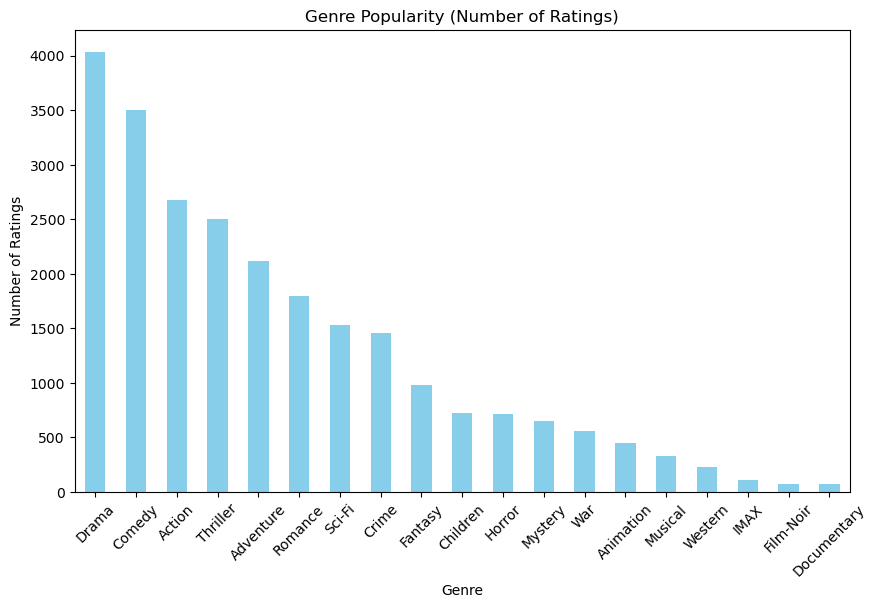

In [93]:
df['genres_split'] = df['genres'].str.split('|')
genre_counts = pd.Series([g for genres in df['genres_split'] for g in genres]).value_counts()
plt.figure(figsize=(10,6))
genre_counts.plot(kind='bar', color='skyblue')
plt.title("Genre Popularity (Number of Ratings)")
plt.ylabel("Number of Ratings")
plt.xlabel("Genre")
plt.xticks(rotation=45)
plt.show()

# Creating user movie matrix for Clustering

In [49]:
user_movie_matrix=df.pivot_table(index='userId',columns='title',values='rating').fillna(0)
print(user_movie_matrix)
ss=StandardScaler()
scaled_user_movie_matrix=ss.fit_transform(user_movie_matrix)

title   'burbs, The (1989)  'night Mother (1986)  \
userId                                             
1                      0.0                   0.0   
2                      0.0                   0.0   
3                      0.0                   0.0   
4                      0.0                   0.0   
5                      0.0                   0.0   
...                    ...                   ...   
87                     0.0                   0.0   
88                     0.0                   0.0   
89                     0.0                   0.0   
90                     0.0                   0.0   
91                     0.0                   0.0   

title   *batteries not included (1987)  ...And Justice for All (1979)  \
userId                                                                  
1                                  0.0                            0.0   
2                                  0.0                            0.0   
3                              

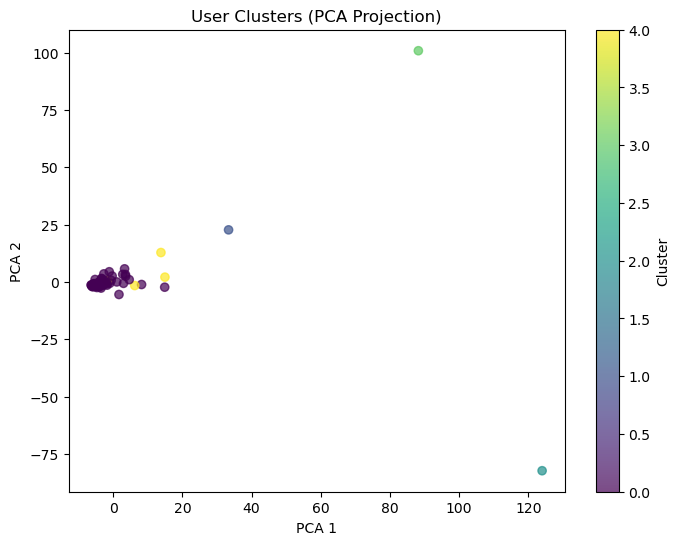

In [71]:
pca = PCA(n_components=2)
user_coords = pca.fit_transform(scaled_user_movie_matrix)
plt.figure(figsize=(8,6))
plt.scatter(user_coords[:,0], user_coords[:,1], c=user_clusters, cmap='viridis', alpha=0.7)
plt.colorbar(label='Cluster')
plt.title("User Clusters (PCA Projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

# Kmeans Clustering

In [50]:
kmeans=KMeans(n_clusters=5,random_state=42,n_init=10)
user_clusters=kmeans.fit_predict(scaled_user_movie_matrix)
print(user_clusters)
user_movie_matrix['cluster']=user_clusters
df=df.merge(user_movie_matrix['cluster'],on='userId')


c:\Users\Dibyanshu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 4 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 3 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4]


# Creating Like label

In [51]:
df['liked']=(df['rating']>=4).astype(int)

# Feature Engineering

In [52]:
X = pd.get_dummies(df[['cluster','genres']],drop_first=True,dtype='int')
y=df['liked']

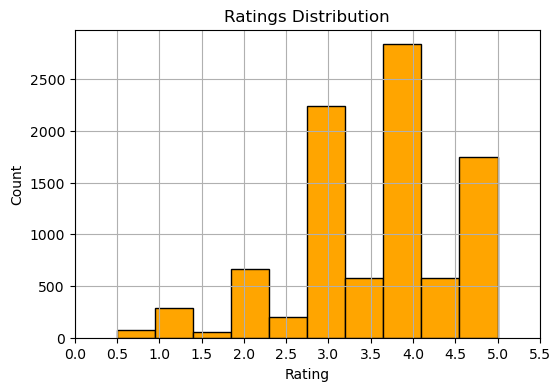

In [102]:
plt.figure(figsize=(6,4))
df['rating'].hist(bins=10, color='orange', edgecolor='black')
plt.title("Ratings Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.xticks(np.arange(0, 6, 0.5))
plt.show()

# Handling Class imbalance with SMOTE

In [53]:
smote = SMOTE(random_state=42)
X_res,y_res=smote.fit_resample(X,y)
print(f"Balanced Dataset: {y_res.value_counts().to_dict()}")


Balanced Dataset: {1: 5163, 0: 5163}


# Train test split

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,train_size=0.8,random_state=42)

# Classification model (RandomForestClassifier)

In [103]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

print("Random Forest Classifier Report:")
print(classification_report( y_test,y_pred))
print("Accuracy Score:",accuracy_score(y_test,y_pred))


Random Forest Classifier Report:
              precision    recall  f1-score   support

           0       0.57      0.64      0.60      1006
           1       0.61      0.54      0.57      1060

    accuracy                           0.59      2066
   macro avg       0.59      0.59      0.59      2066
weighted avg       0.59      0.59      0.59      2066

Accuracy Score: 0.5900290416263311


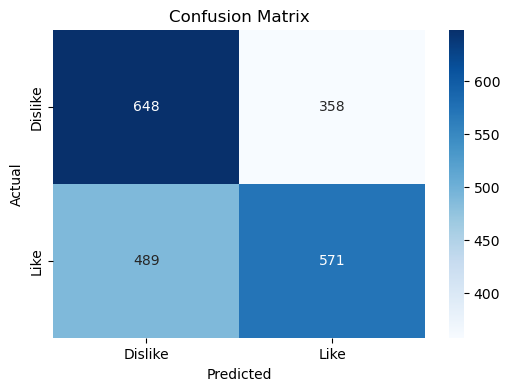

In [110]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Dislike','Like'], yticklabels=['Dislike','Like'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Feature Selection with L1 Regularization

In [104]:
l1_model = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
l1_model.fit(X_train, y_train)

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coef': l1_model.coef_[0]
}).sort_values(by='coef', key=abs, ascending=False)

print("\nTop 10 Important Features (L1):")
print(feature_importance.head(10))


Top 10 Important Features (L1):
                                              feature      coef
220               genres_Adventure|Comedy|Romance|War  2.109871
178  genres_Adventure|Animation|Children|Drama|Sci-Fi  1.777429
251                  genres_Animation|Children|Comedy  1.669759
7     genres_Action|Adventure|Animation|Horror|Sci-Fi  1.560304
271                   genres_Animation|Comedy|Musical  1.551948
38     genres_Action|Adventure|Drama|Mystery|Thriller  1.549198
37              genres_Action|Adventure|Drama|Fantasy  1.547787
219                   genres_Adventure|Comedy|Romance -1.441716
134                       genres_Action|Drama|Western  1.429183
325                   genres_Comedy|Drama|Romance|War  1.409134


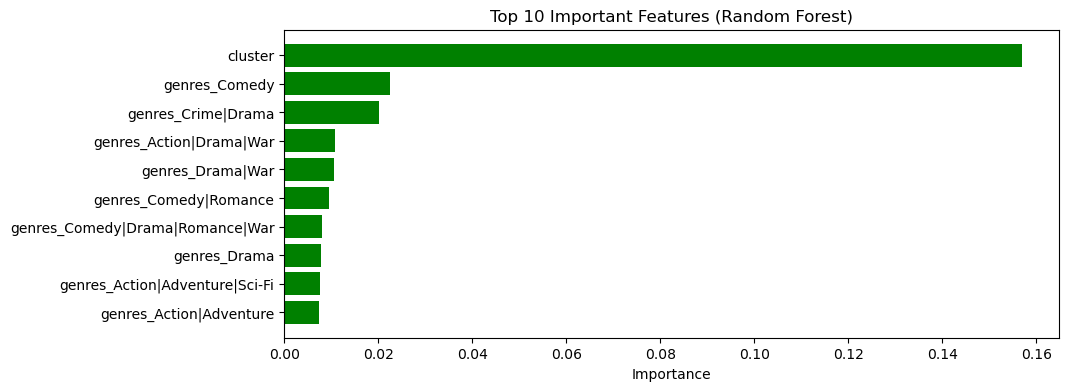

In [119]:
importances = rfc.feature_importances_
indices = np.argsort(importances)[-10:]
plt.figure(figsize=(10,4))
plt.barh(range(len(indices)), importances[indices], color='green', align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.title("Top 10 Important Features (Random Forest)")
plt.xlabel("Importance")
plt.show()